In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Normalización
from sklearn.preprocessing import StandardScaler

# Reducción de Dimensionalidad
from umap import UMAP
from sklearn.decomposition import PCA

# Fuzzy Clustering
import skfuzzy as fuzz

# Metricas
from sklearn.metrics import rand_score, adjusted_rand_score



/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-10 17:26:38.086463: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 17:26:38.140185: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 17:26:38.416548: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 17:26:38.418568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized t

In [3]:
def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = rand_score(Labels_orig, Labels_clust)
    arand= adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct


In [4]:
# Selecciono N filas de cada archivo input. 

DEFAULT_LENGTH = 15000 
SAMPLE_LENGTH = 3000

prefijo = "features_completos_"
sufijo = ".csv.gz"
clases = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
input_folder = "output/datasets/"
input_paths = [input_folder+prefijo+c+sufijo for c in clases]


sample_df = pd.DataFrame()
for clase in clases:
    path = input_folder+prefijo+clase+sufijo
    ids = np.random.choice(np.arange(0,DEFAULT_LENGTH,1), size=SAMPLE_LENGTH, replace=False)
    df = pd.read_csv(path) 
    df = df.loc[ids, :].reset_index(drop=True)
    sample_df = pd.concat([sample_df, df], axis=0)
    print(clase, sample_df.shape)



Arborio (3000, 4104)
Basmati (6000, 4104)
Ipsala (9000, 4104)
Jasmine (12000, 4104)
Karacadag (15000, 4104)


In [6]:
default_cols = ['image_id','class_name']
morphological_features = ['area','eccentricity','perimeter', 'orientation','axis_major_length','axis_minor_length']
conv2d_features = [str(i) for i in range(4096)]

sample_features = sample_df.drop(columns = default_cols + morphological_features)
sample_labels = sample_df.class_name.to_list()

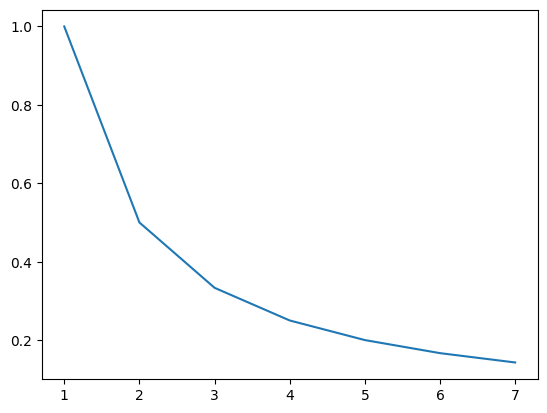

In [7]:
# Uso PCA

ncols = sample_features.shape[1]
n_components = np.min([100, ncols])

scaler = StandardScaler()
scaled = scaler.fit_transform(sample_features)

pca = PCA(n_components=n_components)
scaled_pca = pca.fit(scaled)
Xpca = pca.transform(scaled)

exp_var = scaled_pca.explained_variance_ratio_
# varexp_acum = np.cumsum(exp_var)

# fig, ax = plt.subplots()
# ax.plot(varexp_acum)
# ax.set_title('Varianza Explicada Acumulada', fontsize=8)
# plt.show()

FPCs = []
for n in np.r_[1:8]:
    n_clusters = n
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(Xpca.T, 
                                                    n_clusters, 
                                                    2, 
                                                    error=0.0005, 
                                                    maxiter=1000, 
                                                    init=None)
    FPCs.append(fpc)


fig, ax = plt.subplots()
ax.plot(np.r_[1:8], FPCs)

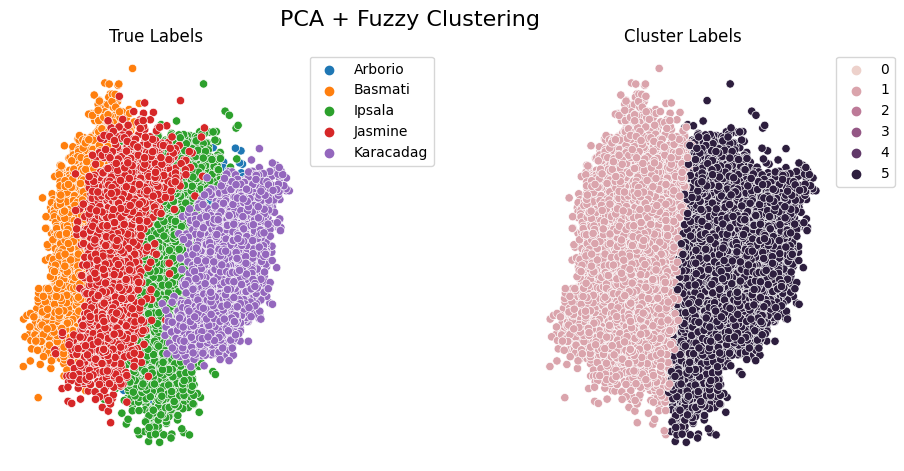

In [8]:


# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

# fig, ax = plt.subplots()
# ax = sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = sample_labels)
# ax.set_xlabel(f"PC1 ({'{0:.2f}%'.format(exp_var[0]*100)})")
# ax.set_ylabel(f"PC2 ({'{0:.2f}%'.format(exp_var[1]*100)})")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = sample_labels, ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = cluster_membership, ax=ax2)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
fig.suptitle("PCA + Fuzzy Clustering", fontsize=16)
ax1.set_title("True Labels")
ax1.axis('off')
ax2.set_title("Cluster Labels")
ax2.axis('off')
plt.subplots_adjust(left=0.1, wspace=0.8, top=0.9)
plt.show()

In [9]:
cross_tab(Labels_orig=sample_labels, Labels_clust=cluster_membership)

RAND score=0.6484, Ajusted RAND=0.2986, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,0,0,5,1,0
1,485,3000,509,2911,0
2,0,0,1,0,0
3,1,0,5,0,0
4,1,0,0,0,0
5,2513,0,2480,88,3000


/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


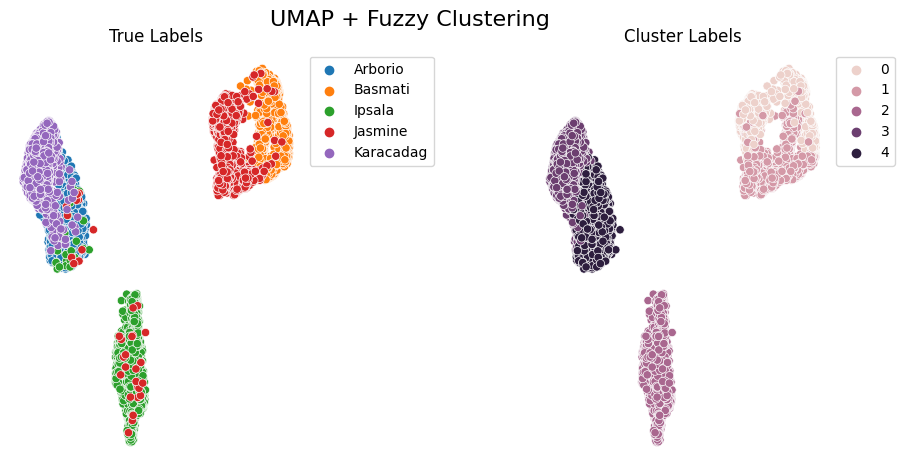

In [10]:
# Uso UMAP

umap = UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=3,
    random_state = 21
)

# Hago el fuzzy clustering
standard_embedding = umap.fit_transform(Xpca)
n_clusters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(standard_embedding.T, 
                                                 n_clusters, 
                                                 2, 
                                                 error=0.005, 
                                                 maxiter=1000, 
                                                 init=None)

# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = sample_labels, ax= ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = cluster_membership, ax=ax2)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
fig.suptitle("UMAP + Fuzzy Clustering", fontsize=16)
ax1.set_title("True Labels")
ax1.axis('off')
ax2.set_title("Cluster Labels")
ax2.axis('off')
plt.subplots_adjust(left=0.1, wspace=0.8, top=0.9)
plt.show()

RAND score=0.9054, Ajusted RAND=0.7046, cantidad_de_muestras=15,000


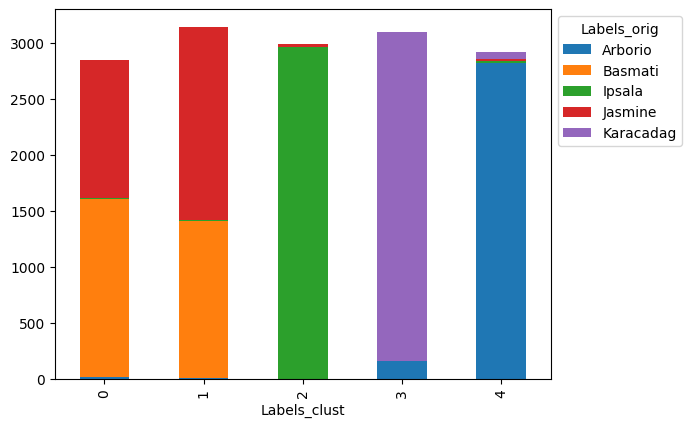

In [11]:
fig, ax = plt.subplots()
cross_tab(sample_labels, cluster_membership).plot(kind="bar", stacked=True, ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [18]:
cross_tab(sample_labels, cluster_membership)/3000

RAND score=0.9211, Ajusted RAND=0.7545, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,0.000333,0.000000,0.987000,0.003000,0.00
1,0.080667,0.000000,0.001000,0.000000,0.97
2,0.004667,0.318333,0.004333,0.832667,0.00
3,0.913667,0.000000,0.007000,0.005667,0.03
4,0.000667,0.681667,0.000667,0.158667,0.00
